<a href="https://colab.research.google.com/github/sunwoongc/data-science-transcription/blob/main/%5B210913%5DIntroduction_to_Ensembling_Stacking_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Source](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python)

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sunnwoongchoi","key":"00037850b93dbb9f6c5993595ede0f49"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [3]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!ls

 gender_submission.csv	 kaggle.json   test.csv
'kaggle (1).json'	 sample_data   train.csv


## Introduction

> In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions

In [5]:
import pandas as pd
import numpy as np
import re

import sklearn
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)

from sklearn.svm import SVC
from sklearn.model_selection import KFold

`from sklearn.cross_validation import KFold` is deprecated, should be updated as 

`from sklearn.model_selection import KFold`

## Feature Exploration, Engineering and Cleaning

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store out passenger ID for easy access
PassengerID = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


ID를 별도로 저장해두면 나중에 사용하기 편합니다.

### Feature Engineering

In [7]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

## Cabin?
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data: ## Random?
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std() 
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
                                                 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mile', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    title_mapping = {"Mr": 1, "Miss":2, "Mrs": 3, "Master":4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3

    dataset['Fare'] = dataset['Fare'].astype(int)

    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

1. `train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)` : nan이면 float 자료형이기 때문에 0이고 그 외에 모든 경우는 1로 처리를 했습니다.

2. 'FamiliySize', 'IsAlone' 등의 특성을 새로 만들어줬습니다. 'FamiliySize'는 가족의 크기가 들어가는 특성일테고, 'IsAlone'의 경우에는 0, 1로 구분만 하는 특성이 될 것 입니다.

3. 'Embarked'의 경우 가장 많은 값인 S로 nan 값을 대체해줬습니다. 이 경우 'Embarked'와 상관관계가 높은 다른 특성을 보면 다르게 대체할 수 있을 지 생각해보는 것도 좋을 것 같습니다.

4. 'Fare'의 경우, 중위수로 NaN값을 대체하고 'CategoricalFare'를 추가했습니다. 이 때 `pd.qcut`을 사용했습니다. qcut은 각 바구니 별로 동일한 n개의 개수를 가지도록 범주를 만드는 함수입니다. 이 [블로그](https://rfriend.tistory.com/404) 와 공식문서를 참고하면 좋습니다.

5. 'Age'의 nan값을 처리하는 방법이 독특했는데, 평균과 표준편차를 구해 그 범위안에서 임의의 정수를 생성하고 채워주는 방법을 선택했습니다. 이 또한 EDA를 통해 더 좋은 방법을 찾아보는 것이 더 좋아보입니다. 여기서도 마지막에는 `qcut`을 사용하고 있습니다.

> 4, 5 모두 `qcut`을 통해 어떤 범위에 속하는 지 정해지면 그 범위를 토대로 7에서 범주화할 때 사용하고 있습니다. 이 방식을 선택하지 않고 바로 범주화를 했을 때 문제가 생기는 지 생각해봐야 할 것 같습니다.

6. 정규표현식을 통해 Mr., Mrs. 꼴등의 'Title'을 찾는 함수를 만들고 이를 apply로 이름에 적용해줍니다. 이렇게 구한 세부적인 'Title'을 조금 더 단순한 범주로 분류했습니다.

7. 'Sex', 'Title', 'Embarked', 'Fare', 'Age' 등을 선택한 범위에 따라 범주화했습니다.

In [8]:
# Feature selection

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

'CategoricalAge', 'CategoricalFare'는 train에만 속하는 column으로 test에서는 별도로 처리해주지 않아도 됩니다. 간단히 제대로 column이 처리됐는 지 확인을 하고 넘어가는 것도 좋은 것 같아 추가해봤습니다.

이처럼 한번에 전처리를 해주는 것도 좋은 방법인 것 같습니다. 항상 EDA를 하면서 전처리를 하는 게 좋을 지, 별도로 다 끝내고 하는 게 좋을 지 헷갈릴 때가 많은데 나름의 기준을 잘 세우고 진행하는 게 좋을 것 같습니다.

In [9]:
set(train.columns) - set(test.columns)

{'Survived'}

'Survived' 컬럼만 test에 빠져있으니 제대로 특성이 부여됐습니다.

### Visualisations

In [10]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


#### Pearson Correlation Heatmap
피어슨 상관계수에 대해서는 wikipedia 및 다른 자료를 통해 한번 정리를 하고 넘어가는 게 좋을 것 같습니다.

**TODO**
- [ ] What is Pearson Correlation?

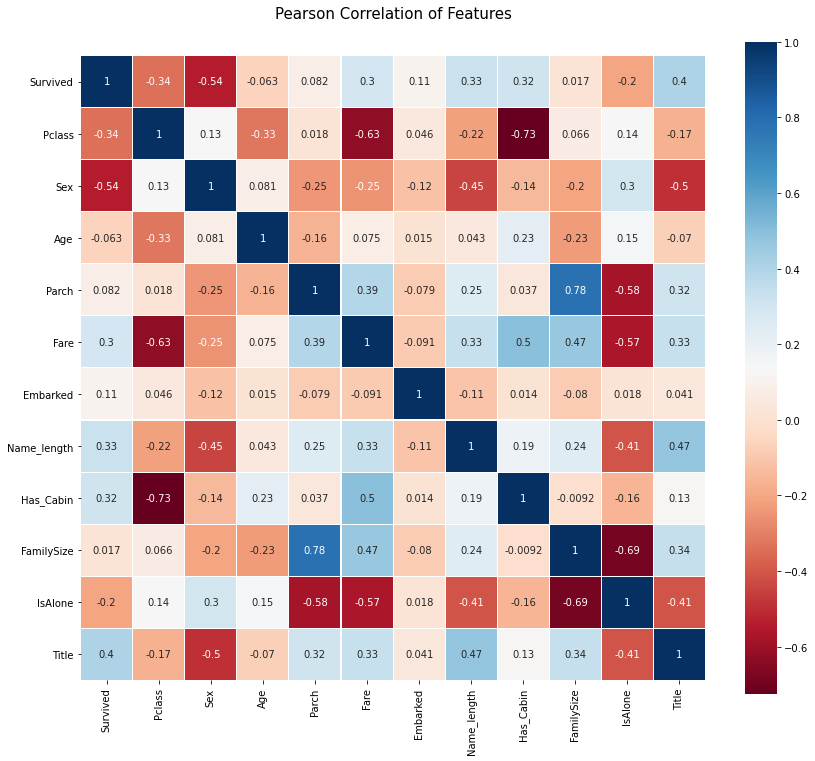

In [11]:
colormap = plt.cm.RdBu
fig, ax = plt.subplots(figsize=(14, 12))
ax.set_title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

상관계수 그림을 통해 확인해볼 수 있는 것은 큰 상관계수를 가지는 특성이 별로 없습니다. 따라서 이는 각각 고유한 특성을 가지는 것으로 이해할 수 있고, 따라서 불필요한 특성이 없다고 생각할 수 있습니다. 'FamilySize', 'Parch' 는 꽤나 큰 상관관계를 보이지만 여기서는 그냥 남겨둔다고 합니다.

추가적으로 이러한 Feature등을 남겨두면 조금 가중치를 두고 학습을 시켜주게 되는 건지 생각해봐야 할 것 같습니다.

`subplots`를 사용해 객체지향으로 시각화를 하는 걸 선호하는 편이라 수정했습니다. 추가적으로 colormap을 이해하고 시각화하는 과정을 꼭 해봐야겠습니다. 막대그래프를 그릴 때 크기에 따라 색을 다르게 하거나 각종 색을 다룰 때 헷갈렸던 적이 많아 이참에 정리를 해봐야겠습니다.

**TODO**
- [ ] How to use colormap properly?

In [12]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0
3,1,1,0,2,0,3,0,44,1,2,0,3.0
4,0,3,1,2,0,1,0,24,0,1,1,1.0


### Pairplots

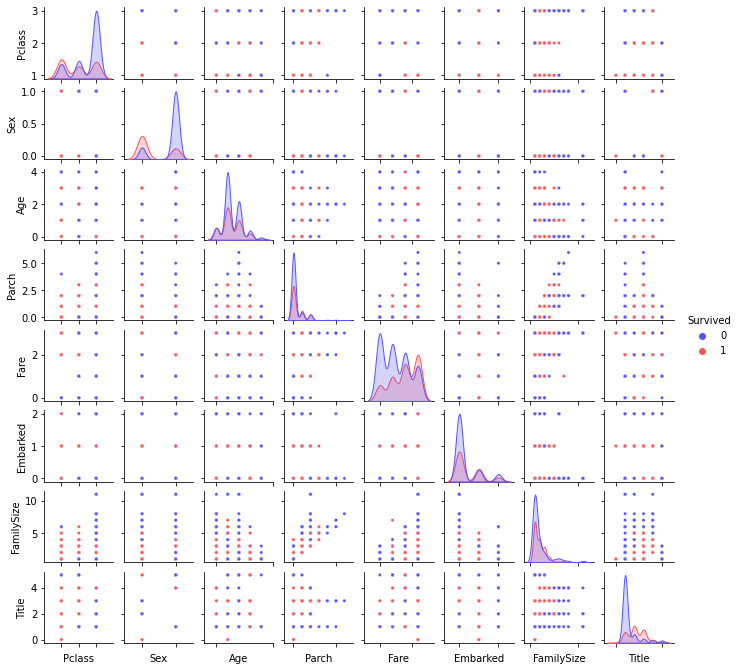

In [14]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age',
                        u'Parch', u'Fare', u'Embarked',
                        u'FamilySize', u'Title']], hue='Survived', palette='seismic',
                 size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))

g.set(xticklabels=[])

Pairplot에 대해서도 좀 더 공부를 해봐야겠습니다.

## Ensembling & Stacking models

### Helpers via Python Classes

앞으로의 모델링 과정을 조금 더 간편히 하기위해 SklearnHelper라는 클래스를 만들어 사용해보겠습니다. OOP를 잘 사용해 클래스 관리를 잘하면 사용하기도 편리하고 보기도 편리한 코드를 작성할 수 있을 것 같습니다.

In [15]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)
        return self.clf.fit(x, y).feature_importances_

1. `sklearn.cross_validation.KFold`가 `sklearn.model_selection.KFold`로 바뀌면서 샘플 수 없이, 나누는 `n_splits`만 선언해주면 되게 변했습니다. 
[old](https://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.KFold.html) [new](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

2. 추가적으로 python에서 asterisk가 사용되는 방법에 대해 알고 넘어가는 것이 좋습니다. [link](https://mingrammer.com/understanding-the-asterisk-of-python/)

기타 클래스 사용법에 대해서는 생략했습니다.

### Out-of-Fold Predictions

스택킹 방법은 base classifier의 예측을 second-level 모델의 입력으로 사용하는 방법입니다. 하지만 전체 train set를 통해 base model을 학습시키고 예측을 전체 test set을 이용해 하게 되면 base model의 예측과정에서 미리 test set을 보게 되는 overfitting의 문제가 생길 수 있습니다.

In [16]:
def get_oof(clf, x_train, y_train, x_test):

    ntrain = train.shape[0]
    ntest = test.shape[0]
    NFOLDS = 5

    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)     
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)  

함수를 이렇게 짠 이유에 대해 조금 더 생각해보기!

### Generation our Base First-Level models.

Sklearn 라이브러리를 이용해 간단히 구현할 수 있는 5개의 모델을 통해 first level classfication을 진행해보겠습니다.

1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine

파라미터들을 미리 정리해보겠습니다.

**Parameters**
* **n_jobs**: 학습과정에서 사용할 core의 갯수

* **n_estimators**: 학습에서 사용할 분류tree(classification tree)의 갯수

* **max_depth**: Tree의 최대 깊이

* **verbose**: 학습과정을 출력하는 mode




In [17]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

위에서 만든 SklearHelper 클래스를 이용해 5개의 모델을 의미하는 objects를 만들겠습니다.

In [18]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets

NumPy array를 이용해 train/test set을 만들어보겠습니다.

In [19]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

### Output of the First level Predictions
1단계 모델의 예측을 출력해보겠습니다.

In [20]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print("Training is complete.")

Training is complete.


### Feature importances generated from the different classifiers

각 분류기마다 feature importance를 출력해 확인해보겠습니다.

In [21]:
rf_features = rf.feature_importances(x_train, y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train, y_train)

[0.12391164 0.20401117 0.03271901 0.02188787 0.07425638 0.02532789
 0.10720368 0.06526915 0.06808473 0.01294054 0.26438795]
[0.12251292 0.38750173 0.03185073 0.01614179 0.05620758 0.02827554
 0.0468628  0.08410572 0.04407223 0.02217863 0.16029033]
[0.032 0.01  0.018 0.066 0.04  0.01  0.684 0.014 0.054 0.    0.072]
[0.08421143 0.01216955 0.0555104  0.01164793 0.05020806 0.02290962
 0.17610809 0.04440593 0.11014875 0.00623308 0.42644718]


SkLearnHelper 클래스 내부 메소드를 수정해 feature_importance를 반환하도록 설정했습니다.

In [22]:
cols = train.columns.values

feature_dataframe = pd.DataFrame( {'features': cols,
                                   'Random Forest feature importances': rf_features,
                                   'Extra Trees feature importances': et_features,
                                   'AdaBoost feature importances': ada_features,
                                   'Gradient Boost feature importances': gb_features})

In [23]:
feature_dataframe.head()

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.123912,0.122513,0.032,0.084211
1,Sex,0.204011,0.387502,0.010,0.012170
2,Age,0.032719,0.031851,0.018,0.055510
3,Parch,0.021888,0.016142,0.066,0.011648
4,Fare,0.074256,0.056208,0.040,0.050208


### Interactive feature importances via Plotly scatterplots

Plotly를 활용해 시각화를 해보겠습니다.

In [24]:
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [ trace ]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2021')
fig.show()

In [25]:
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [ trace ]

layout = go.Layout(
    autosize=True,
    title='Extra Trees feature importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2021')
fig.show()

In [26]:
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [ trace ]

layout = go.Layout(
    autosize=True,
    title='AdaBoost feature importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2021')
fig.show()

In [27]:
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale = 'Portland',
        showscale = True
    ),
    text = feature_dataframe['features'].values
)

data = [ trace ]

layout = go.Layout(
    autosize=True,
    title='Gradient Boost feature importances',
    hovermode = 'closest',
    yaxis = dict(
        title = 'Feature Importance',
        ticklen = 5,
        gridwidth = 2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2021')
fig.show()

### Plotly Barplot of Average Feature Importances

In [28]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.123912,0.122513,0.032,0.084211,0.090659
1,Sex,0.204011,0.387502,0.010,0.012170,0.153421
2,Age,0.032719,0.031851,0.018,0.055510,0.034520


In [29]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions from the First-level Output

이제 첫번째 단계에서 만든 출력으로 Second-Level Predictions을 진행해보겠습니다.

In [31]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
                                        'ExtraTrees': et_oof_train.ravel(),
                                        'AdaBoost': ada_oof_train.ravel(),
                                        'GradientBoost': gb_oof_train.ravel()
                                        })

base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [32]:
data = [
        go.Heatmap(
            z=base_predictions_train.astype(float).corr().values,
            x=base_predictions_train.columns.values,
            y=base_predictions_train.columns.values,
            colorscale='Viridis',
            showscale=True,
            reversescale=True
        )
]

py.iplot(data, filename='labelled-heatmap')

In [33]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train,
                          gb_oof_train, svc_oof_train), axis=1)

x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test,
                         gb_oof_test, svc_oof_test), axis=1)

### Second level learning model via XGBoost

XGBoost를 이용해서 second level 학습을 해보겠습니다.

In [34]:
gbm = xgb.XGBClassifier(
    n_estimators = 2000,
    max_depth = 4,
    min_child_weight = 2,
    gamma = 0.9,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    nthread = -1,
    scale_pos_weight = 1).fit(x_train, y_train)

predictions = gbm.predict(x_test)

### Producing the Submission file

In [35]:
StackingSubmission = pd.DataFrame({'PassengerId': PassengerID,
                                   'Survived': predictions})

StackingSubmission.to_csv("StackingSubmission.csv", index=False)